In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mne import read_epochs, compute_rank, create_info, set_log_level, concatenate_epochs
from mne.decoding import CSP
from random import randint
from sklearn import svm
from mne.preprocessing import ICA
from mne.time_frequency import tfr_multitaper
from mne.decoding import UnsupervisedSpatialFilter
from mne.time_frequency import AverageTFR

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, LeaveOneOut, StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, ShuffleSplit

from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [11]:
set_log_level('warning')
epochs = read_epochs('ica_epo.fif')

 CSP + LDA classification

In [12]:
conditions = ['left','rest']
subset = epochs[conditions].copy()
subset.drop_channels(subset.info['bads'])
subset = subset.pick(['eeg'])
subset

Number of events,42
Events,left: 21rest: 21
Time range,-2.000 – 7.999 sec
Baseline,off


In [13]:
lda = LinearDiscriminantAnalysis(solver='lsqr',shrinkage='auto')
knn = KNeighborsClassifier(n_neighbors=3)
svm_rbf = svm.SVC(kernel="rbf")
rf = RandomForestClassifier(random_state=0)
pca = PCA(n_components=.80)
le = LabelEncoder()

In [14]:
freqs = [2.,7.,18.,35.,60.,90.,110.,120.,140]
freq_tags= ['2-7Hz','7-18','18-35','35-60','60-90','90-110','110-120','120-140']
freq_ranges = list(zip(freqs[:-1], freqs[1:]))

In [15]:
subset = subset.apply_baseline((-1.4,-0.4))
y = le.fit_transform(subset.events[:,2])
full_chance = np.mean(y == y[0])
full_chance = max(full_chance, 1. - full_chance)

Classification with different time, csp and freqs

In [16]:
scores = []
time_config = [
    (1,0.2,1000,0),
    (3,0.2,300,0), 
    (3,0.2,400,100), 
    (3,0.4,300,100), 
    (3,0.4,400,200), 
    (3,0.4,500,200), 
]
components = [2,4,8,10,12]

In [17]:
test_data = subset.copy().crop(0.2,1.9).filter(18, 35).get_data()
test_accuracy('csp_left_rest.npy',test_data, 10, (3,0.2,300,0))

lda :  0.5857142857142857 svm:  0.5642857142857144 knn 0.5785714285714286 rf 0.5904761904761906


running config 1 .
[0.45       0.51111111 0.48333333 0.49722222 0.49444444 0.51666667
 0.53333333 0.52777778]
[0.47777778 0.41111111 0.4        0.41111111 0.44444444 0.41111111
 0.5        0.47777778]
[0.45833333 0.46666667 0.51944444 0.46388889 0.46111111 0.46388889
 0.45833333 0.45277778]
[0.44444444 0.43333333 0.56666667 0.5        0.51111111 0.52222222
 0.5        0.44444444]
running config 2 ..
[0.43333333 0.51388889 0.55833333 0.43055556 0.45277778 0.43888889
 0.45       0.45833333]
[0.5        0.47777778 0.54444444 0.45555556 0.38888889 0.43333333
 0.45555556 0.45555556]
[0.45555556 0.46111111 0.55       0.46111111 0.43611111 0.40833333
 0.41944444 0.42222222]
[0.43333333 0.57777778 0.6        0.47777778 0.52222222 0.36666667
 0.42222222 0.38888889]
[0.47222222 0.51388889 0.56388889 0.46666667 0.45       0.43611111
 0.43611111 0.43333333]
[0.51111111 0.63333333 0.62222222 0.51111111 0.47777778 0.47777778
 0.44444444 0.47777778]
running config 3 ...
running config 4 ....


C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

running config 5 .....


C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

[0.45555556 0.5        0.52777778 0.44444444 0.43888889 0.44444444
 0.44166667 0.43333333]
[0.34444444 0.57777778 0.7        0.54444444 0.4        0.44444444
 0.41111111 0.41111111]


C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

running config 6 ......


C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

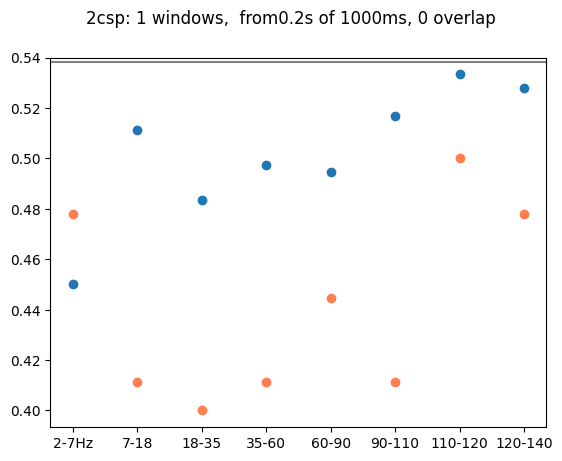

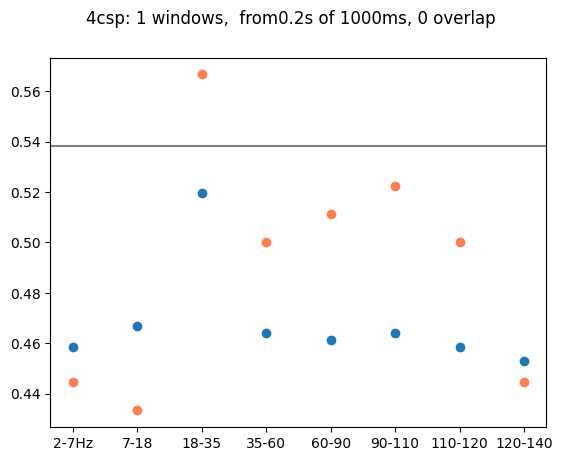

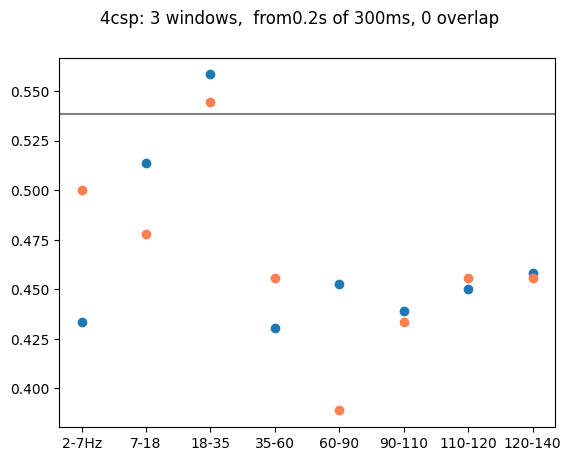

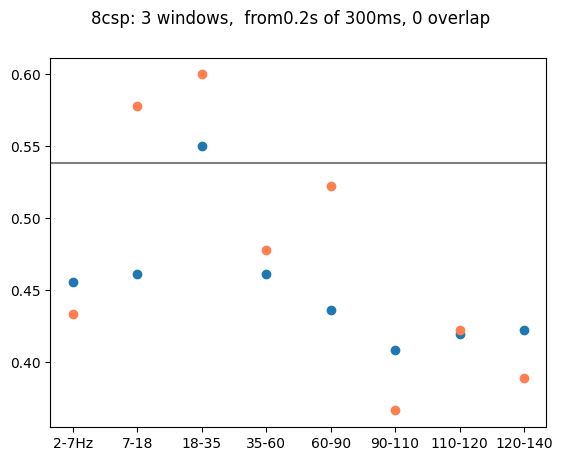

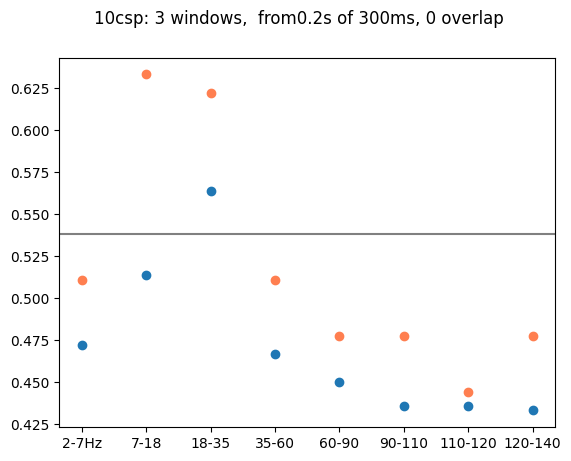

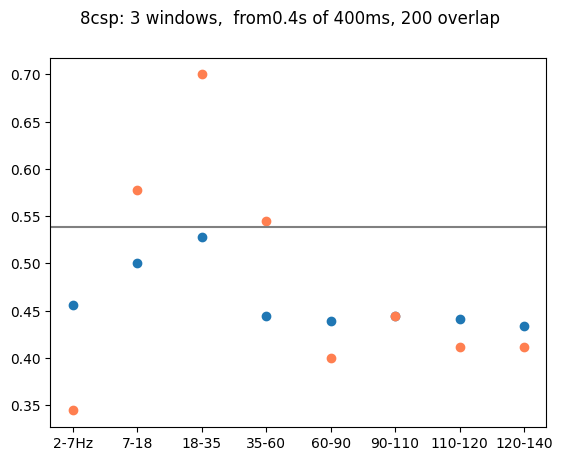

In [9]:
find_best_accuracy()

left vs rest 

In [18]:
conditions = ['left','right']
subset = epochs[conditions].copy()
subset.drop_channels(subset.info['bads'])
subset = subset.pick(['eeg'])
subset

Number of events,40
Events,left: 21right: 19
Time range,-2.000 – 7.999 sec
Baseline,off


In [19]:
subset = subset.apply_baseline((-1.4,-0.4))
y = le.fit_transform(subset.events[:,2])
full_chance = np.mean(y == y[0])
full_chance = max(full_chance, 1. - full_chance)

In [20]:
test_data = subset.copy().crop(0.2,1.9).filter(18, 35).get_data()
test_accuracy('csp_left_right.npy',test_data, 2, (1,0.2,1000,0))

lda :  0.535897435897436 svm:  0.5562271062271062 knn 0.5340659340659341 rf 0.565934065934066


running config 1 .
[0.43888889 0.49444444 0.55277778 0.50277778 0.48611111 0.46111111
 0.45       0.45277778]
[0.46666667 0.42222222 0.57777778 0.54444444 0.51111111 0.51111111
 0.47777778 0.46666667]
running config 2 ..
running config 3 ...
running config 4 ....


C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

running config 5 .....


C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

running config 6 ......


C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:29: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965

C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:95: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.py:96: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\at18157\AppData\Local\Temp\ipykernel_3668\3714965853.

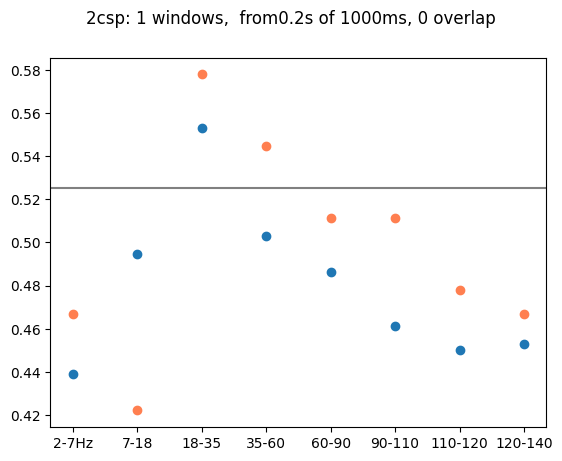

In [12]:
find_best_accuracy()

In [9]:
def test_accuracy(file_name, train_data, cmp, cnf):
    lda_score = []
    svm_score = []
    knn_score = []
    rf_score = []
    
    n_windows, t_min, width, overlap = cnf
    for train_rep in range(10):
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=randint(15,25) + train_rep)
        cv_split = cv.split(train_data, y)

        for train_idx, test_idx in cv_split:
            y_train, y_test = y[train_idx], y[test_idx]

            csp = CSP(n_components=cmp, reg=None, log=True, norm_trace=False, rank='info')
            csp.fit(train_data[train_idx],y_train)            
            
            x_train = []
            x_test = []
            
            w_min = 0
            
            for i in range(n_windows):
                w_max = w_min + width
                x_train.append(csp.transform(train_data[train_idx,:,w_min:w_max]))
                x_test.append(csp.transform(train_data[test_idx,:,w_min:w_max]))
                w_min += w_max - overlap

            x_train = np.concatenate(x_train, axis=1)
            x_test = np.concatenate(x_test, axis=1)
            
            lda.fit(x_train, y_train)
            lda_score.append(np.median(lda.score(x_test, y_test)))
            svm_rbf.fit(x_train, y_train)
            svm_score.append(np.median(svm_rbf.score(x_test,y_test)))
            knn.fit(x_train, y_train)
            knn_score.append(np.median(knn.score(x_test, y_test)))
            rf.fit(x_train, y_train)
            rf_score.append(np.median(rf.score(x_test, y_test)))
    
    print('lda : ',np.mean(lda_score), 'svm: ', np.mean(svm_score), 
          'knn', np.mean(knn_score), 'rf', np.mean(rf_score))
    np.save(file_name,[np.mean(lda_score), np.mean(svm_score), np.mean(knn_score), np.mean(rf_score)])
  
            

In [8]:
def find_best_accuracy():
    optimal_config = [0,0,0,0,0]
    max_accuracy = 0
    cnf_i = 0
    best_score = 0
    best_val_score = 0
    best_config = [0,0,0]
    for cnf in time_config:
        print('running config',cnf_i+1,'.'*(cnf_i+1))
        n_windows, t_min, width, overlap = cnf
        component_score = []
        cmp_i = 0
        for cmp in components:
            csp = CSP(n_components=cmp, reg=None, log=True, norm_trace=False, rank='info')

            test_rep_train_score = []
            test_rep_test_score = []
            for test_rep in range(9) :
                #split training set
                train_epochs, test_epochs, y_train, y_test = train_test_split(subset, y)
                train_epochs = concatenate_epochs(train_epochs)
                test_epochs = concatenate_epochs(test_epochs)
                chance = np.mean(y_train == y_train[0])
                chance = max(chance, 1. - chance)

                freq_scores_mean = []
                for freq, (fmin, fmax) in enumerate(freq_ranges):
                    X = []
                    train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()

                    cv_score = []
                    for val_rep in range(5):
                        cv = ShuffleSplit(n_splits=3, test_size=0.25, random_state=25 + val_rep)
                        cv_split = cv.split(train_data)
                        single_scr = []
                        for train_idx, test_idx in cv_split:
                                y_train_train, y_test_train = y_train[train_idx], y_train[test_idx]
                                X_train = []
                                X_test = []
                                csp.fit(train_data[train_idx], y_train_train)
                                w_min = 0
                                for i in range(n_windows):
                                    w_max = w_min + width
                                    X_train.append(csp.transform(train_data[train_idx,:,w_min:w_max]))
                                    X_test.append(csp.transform(train_data[test_idx,:,w_min:w_max]))
                                    w_min += w_max - overlap

                                X_train = np.concatenate(np.array(X_train), axis=1)
                                X_test = np.concatenate(np.array(X_test), axis=1)
                                if X_train.shape[1] > 7:
                                    X_train = pca.fit_transform(X_train)
                                    X_test = pca.transform(X_test)

                                lda.fit(X_train, y_train_train)
                                single_scr.append(lda.score(X_test, y_test_train))
                        cv_score.append(np.median(single_scr))

                    freq_scores_mean.append(np.mean(cv_score))

                val_scores = validate_config(
                    train_epochs, test_epochs, y_train, y_test, cnf, cmp, freq_scores_mean)
                
                test_rep_test_score.append(val_scores)    
                test_rep_train_score.append(freq_scores_mean)
                
            optimal_config = [cnf_i,cmp,freq]
            
            test_rep_train_score = np.mean(test_rep_train_score, axis=0)
            test_rep_test_score = np.mean(test_rep_test_score, axis=0)
            
            max_train_test_score = np.max(np.mean([test_rep_train_score, test_rep_test_score], axis=0))
            
            if max_train_test_score > best_score : 
                print(test_rep_train_score)
                print(test_rep_test_score)
                csp_fig, axes = plt.subplots(1)
                axes.scatter(freq_tags, test_rep_train_score)
                axes.scatter(freq_tags, test_rep_test_score, color='coral')
                csp_fig.suptitle('{}csp: {} windows,  from{}s of {}ms, {} overlap'.format(optimal_config[1],n_windows,t_min,width,overlap))
                axes.axhline(full_chance, c='grey')
               
                best_score = max_train_test_score
        
            cmp_i += 1    
        cnf_i += 1
        
def validate_config(train_epochs, test_epochs, y_train, y_test, config, csp, train_scores):
    n_windows, t_min, width, overlap = config
    csp = CSP(n_components=csp, reg=None, log=True, norm_trace=False, rank='info')
    freq_score = []
    validated = False
    for freq, (fmin, fmax) in enumerate(freq_ranges):
        X_train = []
        X_test = []
        train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
        test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
        
        csp.fit(train_data, y_train)
        w_min = 0
        for i in range(n_windows):
            w_max = w_min + width
            X_train.append(csp.transform(train_data[:,:,w_min:w_max]))
            X_test.append(csp.transform(test_data[:,:,w_min:w_max]))
            w_min += w_max - overlap

        X_train = np.concatenate(np.array(X_train), axis=1)
        X_test = np.concatenate(np.array(X_test), axis=1)
        
        if X_train.shape[1] > 7:
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)
            
        lda.fit(X_train, y_train)
        freq_score.append(lda.score(X_test, y_test))
    
    return freq_score
    